In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms.transforms as transforms

from tqdm import tqdm

TRAIN_IMG_PATH="G:/Dataset/CASIA-HWDB/HWDB-10/train"                  
TEST_IMG_PATH="G:/Dataset/CASIA-HWDB/HWDB-10/test"

BATCH_SIZE = 4
INPUT_SIZE = 3*32*32
HIDDEN_1_SIZE = 512
OUTPUT_SIZE = 10
EPOCH_NUM = 20

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_IMG_PATH, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = torchvision.datasets.ImageFolder(root=TEST_IMG_PATH, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

tensor([4, 3, 6, 1])


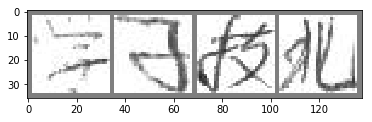

In [2]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5
    nping = img.numpy()
    nping = np.transpose(nping, (1, 2, 0))
    plt.imshow(nping)

dataiter = iter(train_dataloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(labels)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 28 * 28, OUTPUT_SIZE)
        #self.fc2 = nn.Linear(HIDDEN_1_SIZE, OUTPUT_SIZE)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = x.view(-1, 16 * 28 * 28)
        x = self.fc1(x)

        # x = self.fc2(x)

        return x

net = Net().cuda()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=12544, out_features=10, bias=True)
)


In [4]:
criterion = nn.CrossEntropyLoss()

# lr 如何设置 momentum
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [5]:
train_loss_hist = []
test_loss_hist = []

for epoch in tqdm(range(EPOCH_NUM)):
    running_loss = 0.0
    num = 1
    for i, data in enumerate(train_dataloader):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        #print(images.shape)
        outputs = net(images)
        #print(labels)
        #print(outputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        num = i + 1
        if(i % 250 == 0):
            with torch.no_grad():
                for test_data in test_dataloader:
                    test_images, test_labels = test_data
                    test_images = test_images.cuda()
                    test_labels = test_labels.cuda()
                    test_outputs = net(test_images)
                    test_loss = criterion(test_outputs, test_labels)
            
            train_loss_hist.append(running_loss / num)
            test_loss_hist.append(test_loss.item())
            running_loss = 0.0
            num = 1

        # if(i % 1000 == 0):
        #     print('step: %d loss: %.3f' % (i, loss))

100%|██████████| 20/20 [01:50<00:00,  5.52s/it]


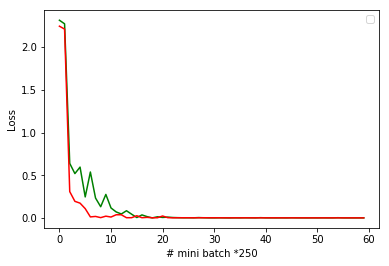

In [6]:
import matplotlib.pyplot as plt

# print(train_loss_hist)
plt.figure()
plt.plot(train_loss_hist, color='green')
plt.plot(test_loss_hist, color='red')
plt.legend('train_loss', 'test_loss')
plt.xlabel('# mini batch *250')
plt.ylabel('Loss')

In [7]:
# 测试模型

correct = 0.0
total = 0.0

with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)

        correct += (predicted == labels).sum()
        total += labels.size(0)
    
print('准确率：', float(correct) / total)

准确率： 0.9216666666666666


In [27]:
# 准确率： 0.8397328881469115   2 fc
# 准确率： 0.9282136894824707   2 cnn

# 修改 mean / std 
# transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# T.Normalize((0.8959238,0.8959238,0.8959238), (0.18494467, 0.18494467, 0.18494467)
# 准确率： 0.9333333333333333

